In [1]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import json
import math
import os
import random

%matplotlib inline

with open("calib/calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]

directory=2

left_movie = cv2.VideoCapture(f'movie/{directory}/left.mp4')
right_movie = cv2.VideoCapture(f'movie/{directory}/right.mp4')
rgb_movie = cv2.VideoCapture(f'movie/{directory}/rgb.mp4')
disparity = cv2.VideoCapture(f'movie/{directory}/disparity.mp4')
confmap = cv2.VideoCapture(f'movie/{directory}/conf.mp4')

left_movie.get(cv2.CAP_PROP_FPS),rgb_movie.get(cv2.CAP_PROP_FPS)

(30.00029977240357, 30.00029977240357)

In [3]:
bl = 75 #mm base line
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]
rfx

850.998291015625

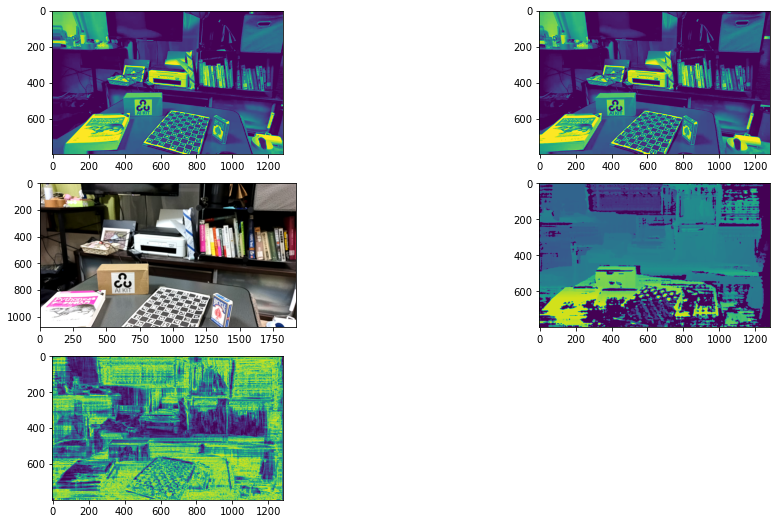

In [4]:
def getframes(frame_num,display=False):
    left_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    right_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    rgb_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    disparity.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    confmap.set(cv2.CAP_PROP_POS_FRAMES,frame_num)

    
    left_ret, left_frame = left_movie.read()
    right_ret, right_frame = right_movie.read()
    rgb_ret,rgb_frame = rgb_movie.read()
#     rgb_frame = cv2.undistort(rgb_frame,np.array(rgb_data["intrinsicMatrix"]),np.array(rgb_data['distortionCoeff']))
#     left_frame = cv2.undistort(left_frame,np.array(left_data["intrinsicMatrix"]),np.array(left_data['distortionCoeff']))
#     right_frame = cv2.undistort(right_frame,np.array(right_data["intrinsicMatrix"]),np.array(right_data['distortionCoeff']))

    dis_ret,dis_frame = disparity.read()
    conf_ret,conf_frame = confmap.read()


    left_frame =cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_frame =cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)
    rgb_frame = cv2.cvtColor(rgb_frame,cv2.COLOR_BGRA2RGB)
    dis_frame = cv2.cvtColor(dis_frame,cv2.COLOR_BGR2GRAY)
    conf_frame = cv2.cvtColor(conf_frame,cv2.COLOR_BGR2GRAY)

    
    if display:
        plt.figure(figsize=(16,9))
        plt.subplot(321).imshow(left_frame,vmin=0, vmax=255)
        plt.subplot(322).imshow(right_frame,vmin=0, vmax=255)
        plt.subplot(323).imshow(rgb_frame)
        plt.subplot(324).imshow(dis_frame)
        plt.subplot(325).imshow(conf_frame)
        
#         plt.imshow(rgb_frame)
        plt.show()
    return left_frame,right_frame,dis_frame,conf_frame


left_frame,right_frame,dis_frame,conf_frame =getframes(20,display=True)

1985 matches found


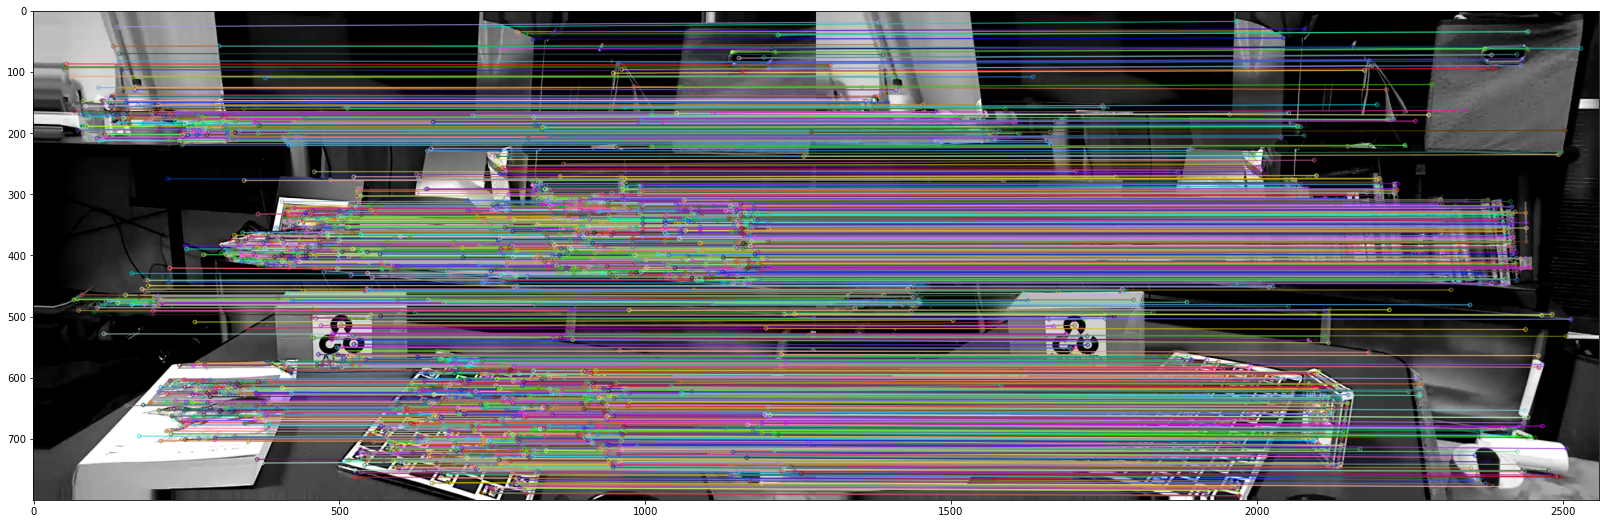

In [7]:
def feature_compute(left_frame,right_frame,feature_detection="SIFT",display=False):
    if feature_detection == "SIFT":
#         feature=cv2.SIFT_create(nOctaveLayers=20,contrastThreshold=0.001,edgeThreshold =100)
        feature=cv2.SIFT_create()
    elif feature_detection == "AKAZE":
#         feature=cv2.AKAZE_create(threshold=0.00000001)
        feature=cv2.AKAZE_create(t) 
    elif feature_detection == "ORB":
         feature=cv2.ORB_create()
    feature_left_kp, feature_left_des = feature.detectAndCompute(left_frame, None)
    feature_right_kp, feature_right_des = feature.detectAndCompute(right_frame, None)
    feature_bf = cv2.BFMatcher(crossCheck=True)
    feature_matches = feature_bf.match(feature_left_des, feature_right_des)

    feature_matches = [i for i in feature_matches if abs(feature_left_kp[i.queryIdx].pt[1]-feature_right_kp[i.trainIdx].pt[1])<10]
    print(len(feature_matches),"matches found")
    
    if display:
        img_feature = cv2.drawMatches(left_frame, feature_left_kp, right_frame , feature_right_kp, feature_matches, None, flags=2)
        plt.figure(figsize=(32,9))
        plt.imshow(img_feature)
        plt.show()
    return feature_left_kp, feature_left_des , feature_right_kp, feature_right_des , feature_matches
feature_left_kp, feature_left_des,feature_right_kp,feature_right_des,feature_matches=feature_compute(left_frame,right_frame,feature_detection="SIFT",display=True)

In [6]:
def make_pcd(right_frame,dis_frame,conf_frame,filename,display=False):
    right_frame_rgb = cv2.applyColorMap(right_frame, cv2.COLORMAP_HOT)
    pointlist=[]
    colors=[]
    for xr in range(dis_frame.shape[0]):
        for yr in range(dis_frame.shape[1]):
            if conf_frame[xr][yr]<8 and dis_frame[xr][yr]>24and dis_frame[xr][yr]<256:
                d = dis_frame[xr][yr]
                z= rfx*bl/d
                x= (xr-rcx)*bl/d
                y= (yr-rcy)*bl/d
                color = right_frame_rgb[xr][yr]/256
                colors.append(color)
                p=[x,y,z]
                pointlist.append(p)

    pointlist=np.asarray(pointlist)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pointlist))
    pcd.colors= o3d.utility.Vector3dVector(np.array(colors))
    o3d.io.write_point_cloud(f"{filename}.ply", pcd)
    if display:
        o3d.visualization.draw_geometries([pcd])
    return pcd
pcd=make_pcd(right_frame,dis_frame,conf_frame,"./fpcd")

In [7]:
frame_count=int(left_movie.get(cv2.CAP_PROP_FRAME_COUNT))
for f in range(1293):
    print(f"now running frame {f}")
    left_frame,right_frame,dis_frame,conf_frame =getframes(f)
    make_pcd(right_frame,dis_frame,conf_frame,f"./frame/{str(f)}/color")

now running frame 0
now running frame 1
now running frame 2
now running frame 3
now running frame 4
now running frame 5
now running frame 6
now running frame 7
now running frame 8
now running frame 9
now running frame 10
now running frame 11
now running frame 12
now running frame 13
now running frame 14
now running frame 15
now running frame 16
now running frame 17
now running frame 18
now running frame 19
now running frame 20
now running frame 21
now running frame 22
now running frame 23
now running frame 24
now running frame 25
now running frame 26
now running frame 27
now running frame 28
now running frame 29
now running frame 30
now running frame 31
now running frame 32
now running frame 33
now running frame 34
now running frame 35
now running frame 36
now running frame 37
now running frame 38
now running frame 39
now running frame 40
now running frame 41
now running frame 42
now running frame 43
now running frame 44
now running frame 45
now running frame 46
now running frame 47
no

now running frame 378
now running frame 379
now running frame 380
now running frame 381
now running frame 382
now running frame 383
now running frame 384
now running frame 385
now running frame 386
now running frame 387
now running frame 388
now running frame 389
now running frame 390
now running frame 391
now running frame 392
now running frame 393
now running frame 394
now running frame 395
now running frame 396
now running frame 397
now running frame 398
now running frame 399
now running frame 400
now running frame 401
now running frame 402
now running frame 403
now running frame 404
now running frame 405
now running frame 406
now running frame 407
now running frame 408
now running frame 409
now running frame 410
now running frame 411
now running frame 412
now running frame 413
now running frame 414
now running frame 415
now running frame 416
now running frame 417
now running frame 418
now running frame 419
now running frame 420
now running frame 421
now running frame 422
now runnin

now running frame 751
now running frame 752
now running frame 753
now running frame 754
now running frame 755
now running frame 756
now running frame 757
now running frame 758
now running frame 759
now running frame 760
now running frame 761
now running frame 762
now running frame 763
now running frame 764
now running frame 765
now running frame 766
now running frame 767
now running frame 768
now running frame 769
now running frame 770
now running frame 771
now running frame 772
now running frame 773
now running frame 774
now running frame 775
now running frame 776
now running frame 777
now running frame 778
now running frame 779
now running frame 780
now running frame 781
now running frame 782
now running frame 783
now running frame 784
now running frame 785
now running frame 786
now running frame 787
now running frame 788
now running frame 789
now running frame 790
now running frame 791
now running frame 792
now running frame 793
now running frame 794
now running frame 795
now runnin

now running frame 1119
now running frame 1120
now running frame 1121
now running frame 1122
now running frame 1123
now running frame 1124
now running frame 1125
now running frame 1126
now running frame 1127
now running frame 1128
now running frame 1129
now running frame 1130
now running frame 1131
now running frame 1132
now running frame 1133
now running frame 1134
now running frame 1135
now running frame 1136
now running frame 1137
now running frame 1138
now running frame 1139
now running frame 1140
now running frame 1141
now running frame 1142
now running frame 1143
now running frame 1144
now running frame 1145
now running frame 1146
now running frame 1147
now running frame 1148
now running frame 1149
now running frame 1150
now running frame 1151
now running frame 1152
now running frame 1153
now running frame 1154
now running frame 1155
now running frame 1156
now running frame 1157
now running frame 1158
now running frame 1159
now running frame 1160
now running frame 1161
now running

In [8]:
def feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches):
    positions = []
    right_descriptions = []
    right_kp = []
    for match in feature_matches:
        left_ind=match.queryIdx
        right_ind=match.trainIdx
        left_pt=feature_left_kp[left_ind].pt
        right_pt=feature_right_kp[right_ind].pt
        d = left_pt[0]-right_pt[0]
        if d < 1:
            pass
        else:
            z=rfx*bl/d
            x= (right_pt[0]-rcx)*bl/d
            y=(right_pt[1]-rcy)*bl/d
            position=[x,y,z]
            description =feature_right_des[right_ind]
            positions.append(position)
            right_descriptions.append(description)
            #! point!!
            right_kp.append(feature_right_kp[right_ind])
    positions = np.asarray(positions)
    right_descriptions=np.asarray(right_descriptions)
    right_kp=np.asarray(right_kp)
    return positions,right_descriptions,right_kp

In [9]:
positions,right_descriptions,right_kp=feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches)
featurepcd = o3d.geometry.PointCloud()
featurepcd.points = o3d.utility.Vector3dVector(positions)
featurepcd.colors = o3d.utility.Vector3dVector(np.tile([1,0,0],[positions.shape[0],1]))

o3d.io.write_point_cloud("featurepcd.ply", featurepcd)

concatpcd = o3d.geometry.PointCloud()

pcdpoints = np.asarray(pcd.points)
pcdcolors = np.asarray(pcd.colors)
featurepoints = np.asarray(featurepcd.points)
featurecolors = np.asarray(featurepcd.colors)

concatpoints = np.concatenate([pcdpoints,featurepoints])
concatcolors = np.concatenate([pcdcolors,featurecolors])

concatpcd.points =  o3d.utility.Vector3dVector(np.array(concatpoints))
concatpcd.colors =  o3d.utility.Vector3dVector(np.array(concatcolors))

o3d.io.write_point_cloud("concatpcd.ply", concatpcd)

True

In [10]:
for t in ["SIFT","AKAZE"]:
    for f in range(1293):
        print(f"now running frame {f}")
        left_frame,right_frame,dis_frame,conf_frame =getframes(f)
        feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches=feature_compute(left_frame,right_frame,feature_detection=t)
        positions,right_descriptions,right_kp=feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches)
        np.savez(f"./{t}/frame{f}",positions=positions,right_descriptions=right_descriptions,right_frame=right_frame)

now running frame 0
517 matches found
now running frame 1
525 matches found
now running frame 2
406 matches found
now running frame 3
429 matches found
now running frame 4
457 matches found
now running frame 5
475 matches found
now running frame 6
474 matches found
now running frame 7
450 matches found
now running frame 8
1395 matches found
now running frame 9
1323 matches found
now running frame 10
1542 matches found
now running frame 11
1698 matches found
now running frame 12
1796 matches found
now running frame 13
1799 matches found
now running frame 14
1771 matches found
now running frame 15
1779 matches found
now running frame 16
1837 matches found
now running frame 17
1883 matches found
now running frame 18
1925 matches found
now running frame 19
1945 matches found
now running frame 20
1985 matches found
now running frame 21
2031 matches found
now running frame 22
2187 matches found
now running frame 23
2159 matches found
now running frame 24
2138 matches found
now running frame 

1345 matches found
now running frame 205
1657 matches found
now running frame 206
1345 matches found
now running frame 207
998 matches found
now running frame 208
1428 matches found
now running frame 209
1340 matches found
now running frame 210
1729 matches found
now running frame 211
1135 matches found
now running frame 212
989 matches found
now running frame 213
1108 matches found
now running frame 214
1503 matches found
now running frame 215
1440 matches found
now running frame 216
1797 matches found
now running frame 217
2101 matches found
now running frame 218
2067 matches found
now running frame 219
1407 matches found
now running frame 220
2068 matches found
now running frame 221
1969 matches found
now running frame 222
2038 matches found
now running frame 223
2154 matches found
now running frame 224
1768 matches found
now running frame 225
1847 matches found
now running frame 226
1901 matches found
now running frame 227
1745 matches found
now running frame 228
1630 matches found

708 matches found
now running frame 408
720 matches found
now running frame 409
670 matches found
now running frame 410
686 matches found
now running frame 411
671 matches found
now running frame 412
1107 matches found
now running frame 413
1036 matches found
now running frame 414
1115 matches found
now running frame 415
1061 matches found
now running frame 416
1109 matches found
now running frame 417
897 matches found
now running frame 418
955 matches found
now running frame 419
963 matches found
now running frame 420
950 matches found
now running frame 421
973 matches found
now running frame 422
1127 matches found
now running frame 423
1093 matches found
now running frame 424
991 matches found
now running frame 425
1000 matches found
now running frame 426
942 matches found
now running frame 427
1000 matches found
now running frame 428
1076 matches found
now running frame 429
1187 matches found
now running frame 430
1210 matches found
now running frame 431
1041 matches found
now runni

766 matches found
now running frame 609
709 matches found
now running frame 610
679 matches found
now running frame 611
905 matches found
now running frame 612
927 matches found
now running frame 613
761 matches found
now running frame 614
765 matches found
now running frame 615
838 matches found
now running frame 616
832 matches found
now running frame 617
894 matches found
now running frame 618
906 matches found
now running frame 619
1032 matches found
now running frame 620
1024 matches found
now running frame 621
1198 matches found
now running frame 622
1103 matches found
now running frame 623
980 matches found
now running frame 624
1018 matches found
now running frame 625
991 matches found
now running frame 626
772 matches found
now running frame 627
794 matches found
now running frame 628
810 matches found
now running frame 629
1018 matches found
now running frame 630
582 matches found
now running frame 631
583 matches found
now running frame 632
821 matches found
now running fram

1261 matches found
now running frame 812
1236 matches found
now running frame 813
1254 matches found
now running frame 814
1238 matches found
now running frame 815
1243 matches found
now running frame 816
965 matches found
now running frame 817
1085 matches found
now running frame 818
1516 matches found
now running frame 819
1419 matches found
now running frame 820
1187 matches found
now running frame 821
1518 matches found
now running frame 822
1388 matches found
now running frame 823
1441 matches found
now running frame 824
1119 matches found
now running frame 825
1369 matches found
now running frame 826
1465 matches found
now running frame 827
1330 matches found
now running frame 828
1450 matches found
now running frame 829
1444 matches found
now running frame 830
1470 matches found
now running frame 831
1550 matches found
now running frame 832
1090 matches found
now running frame 833
1142 matches found
now running frame 834
1333 matches found
now running frame 835
1487 matches foun

951 matches found
now running frame 1015
897 matches found
now running frame 1016
944 matches found
now running frame 1017
1045 matches found
now running frame 1018
1350 matches found
now running frame 1019
1178 matches found
now running frame 1020
1178 matches found
now running frame 1021
1428 matches found
now running frame 1022
1194 matches found
now running frame 1023
1527 matches found
now running frame 1024
1116 matches found
now running frame 1025
756 matches found
now running frame 1026
974 matches found
now running frame 1027
792 matches found
now running frame 1028
915 matches found
now running frame 1029
1158 matches found
now running frame 1030
1196 matches found
now running frame 1031
1268 matches found
now running frame 1032
1390 matches found
now running frame 1033
1824 matches found
now running frame 1034
1833 matches found
now running frame 1035
1781 matches found
now running frame 1036
1731 matches found
now running frame 1037
1695 matches found
now running frame 1038

741 matches found
now running frame 1212
803 matches found
now running frame 1213
847 matches found
now running frame 1214
844 matches found
now running frame 1215
892 matches found
now running frame 1216
934 matches found
now running frame 1217
894 matches found
now running frame 1218
705 matches found
now running frame 1219
837 matches found
now running frame 1220
830 matches found
now running frame 1221
794 matches found
now running frame 1222
857 matches found
now running frame 1223
1170 matches found
now running frame 1224
1413 matches found
now running frame 1225
1300 matches found
now running frame 1226
1378 matches found
now running frame 1227
1561 matches found
now running frame 1228
1438 matches found
now running frame 1229
1026 matches found
now running frame 1230
1069 matches found
now running frame 1231
1048 matches found
now running frame 1232
857 matches found
now running frame 1233
794 matches found
now running frame 1234
908 matches found
now running frame 1235
817 mat

1658 matches found
now running frame 121
1445 matches found
now running frame 122
877 matches found
now running frame 123
1426 matches found
now running frame 124
1410 matches found
now running frame 125
1540 matches found
now running frame 126
1636 matches found
now running frame 127
1672 matches found
now running frame 128
1375 matches found
now running frame 129
1411 matches found
now running frame 130
1572 matches found
now running frame 131
1711 matches found
now running frame 132
1667 matches found
now running frame 133
1698 matches found
now running frame 134
1701 matches found
now running frame 135
1266 matches found
now running frame 136
1064 matches found
now running frame 137
1353 matches found
now running frame 138
1378 matches found
now running frame 139
1217 matches found
now running frame 140
980 matches found
now running frame 141
848 matches found
now running frame 142
656 matches found
now running frame 143
938 matches found
now running frame 144
1271 matches found
no

971 matches found
now running frame 322
1077 matches found
now running frame 323
978 matches found
now running frame 324
1219 matches found
now running frame 325
1234 matches found
now running frame 326
1260 matches found
now running frame 327
1282 matches found
now running frame 328
1199 matches found
now running frame 329
1236 matches found
now running frame 330
1219 matches found
now running frame 331
1168 matches found
now running frame 332
1173 matches found
now running frame 333
1160 matches found
now running frame 334
1166 matches found
now running frame 335
1152 matches found
now running frame 336
1175 matches found
now running frame 337
1134 matches found
now running frame 338
1213 matches found
now running frame 339
1119 matches found
now running frame 340
1071 matches found
now running frame 341
1053 matches found
now running frame 342
1128 matches found
now running frame 343
1221 matches found
now running frame 344
1221 matches found
now running frame 345
1290 matches found

2019 matches found
now running frame 523
1620 matches found
now running frame 524
1959 matches found
now running frame 525
1979 matches found
now running frame 526
1836 matches found
now running frame 527
1774 matches found
now running frame 528
1865 matches found
now running frame 529
1743 matches found
now running frame 530
1611 matches found
now running frame 531
1584 matches found
now running frame 532
1752 matches found
now running frame 533
1784 matches found
now running frame 534
1771 matches found
now running frame 535
1665 matches found
now running frame 536
1595 matches found
now running frame 537
1719 matches found
now running frame 538
1434 matches found
now running frame 539
1742 matches found
now running frame 540
1496 matches found
now running frame 541
1724 matches found
now running frame 542
1629 matches found
now running frame 543
1677 matches found
now running frame 544
1775 matches found
now running frame 545
1790 matches found
now running frame 546
1800 matches fou

1983 matches found
now running frame 724
1930 matches found
now running frame 725
1693 matches found
now running frame 726
1818 matches found
now running frame 727
1655 matches found
now running frame 728
1774 matches found
now running frame 729
1530 matches found
now running frame 730
1486 matches found
now running frame 731
1478 matches found
now running frame 732
1252 matches found
now running frame 733
1417 matches found
now running frame 734
1273 matches found
now running frame 735
1204 matches found
now running frame 736
1160 matches found
now running frame 737
1343 matches found
now running frame 738
1225 matches found
now running frame 739
1313 matches found
now running frame 740
1304 matches found
now running frame 741
1213 matches found
now running frame 742
894 matches found
now running frame 743
929 matches found
now running frame 744
1196 matches found
now running frame 745
1132 matches found
now running frame 746
1189 matches found
now running frame 747
1004 matches found

1219 matches found
now running frame 925
1325 matches found
now running frame 926
1329 matches found
now running frame 927
1376 matches found
now running frame 928
1386 matches found
now running frame 929
1171 matches found
now running frame 930
1400 matches found
now running frame 931
1199 matches found
now running frame 932
1098 matches found
now running frame 933
1056 matches found
now running frame 934
1229 matches found
now running frame 935
1205 matches found
now running frame 936
1032 matches found
now running frame 937
977 matches found
now running frame 938
1069 matches found
now running frame 939
958 matches found
now running frame 940
972 matches found
now running frame 941
840 matches found
now running frame 942
822 matches found
now running frame 943
882 matches found
now running frame 944
834 matches found
now running frame 945
845 matches found
now running frame 946
774 matches found
now running frame 947
752 matches found
now running frame 948
753 matches found
now runn

1267 matches found
now running frame 1124
1279 matches found
now running frame 1125
1197 matches found
now running frame 1126
1254 matches found
now running frame 1127
1140 matches found
now running frame 1128
1162 matches found
now running frame 1129
1292 matches found
now running frame 1130
1266 matches found
now running frame 1131
1215 matches found
now running frame 1132
1213 matches found
now running frame 1133
1028 matches found
now running frame 1134
1101 matches found
now running frame 1135
942 matches found
now running frame 1136
960 matches found
now running frame 1137
1027 matches found
now running frame 1138
1088 matches found
now running frame 1139
1195 matches found
now running frame 1140
1228 matches found
now running frame 1141
1591 matches found
now running frame 1142
1610 matches found
now running frame 1143
1671 matches found
now running frame 1144
1587 matches found
now running frame 1145
1514 matches found
now running frame 1146
1569 matches found
now running frame

In [11]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(t1_descriptions,t2_descriptions)
#     good_matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [12]:
def frame_data(f,feature_detection= "SIFT"):
    left_frame,right_frame,dis_frame,conf_frame =getframes(f)
    feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches=feature_compute(left_frame,right_frame,feature_detection=feature_detection)    
    pcd=make_pcd(right_frame,dis_frame,conf_frame,"./fpcd")
    positions,right_descriptions,right_kp=feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches)
    
    np.random.seed(f)
    c = np.random.rand(3)
    featurepcd = o3d.geometry.PointCloud()
    featurepcd.points = o3d.utility.Vector3dVector(positions)
    featurepcd.colors = o3d.utility.Vector3dVector(np.tile(c,[positions.shape[0],1]))

    concatpcd = o3d.geometry.PointCloud()

    pcdpoints = np.asarray(pcd.points)
    pcdcolors = np.asarray(pcd.colors)
    featurepoints = np.asarray(featurepcd.points)
    featurecolors = np.asarray(featurepcd.colors)

    concatpoints = np.concatenate([pcdpoints,featurepoints])
    concatcolors = np.concatenate([pcdcolors,featurecolors])

    concatpcd.points =  o3d.utility.Vector3dVector(np.array(concatpoints))
    concatpcd.colors =  o3d.utility.Vector3dVector(np.array(concatcolors))
    
    result = {
        "left_frame":left_frame,
        "right_frame":right_frame,
        "dis_frame":dis_frame,
        "conf_frame":conf_frame,
        "feature_left_kp":feature_left_kp,
        "feature_left_des":feature_left_des,
        "feature_right_kp":feature_right_kp,
        "feature_right_des":feature_right_des,
        "feature_matches":feature_matches,
        "pcd":pcd,
        "positions":positions,
        "right_descriptions":right_descriptions,
        "right_kp":right_kp,
        "featurepcd":featurepcd,
        "concatpcd":concatpcd
    }
    return result

akaze_t1_frame = frame_data(1,feature_detection="AKAZE")
akaze_t2_frame = frame_data(2,feature_detection="AKAZE")
sift_t1_frame = frame_data(1)
sift_t2_frame = frame_data(2)

1017 matches found
1031 matches found
525 matches found
406 matches found


252
725


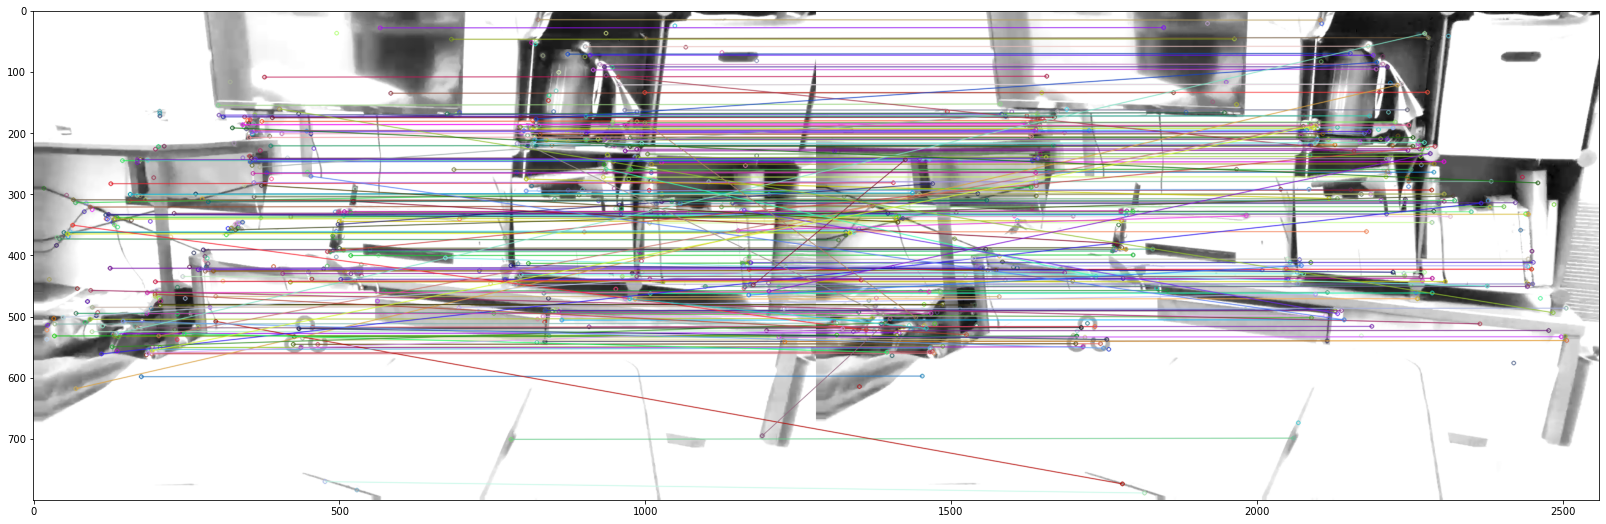

In [13]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(t1_descriptions,t2_descriptions)
    good_matches = sorted(matches, key=lambda x: x.distance)
    return good_matches
sift_good_matches = match_by_frame(sift_t1_frame["right_descriptions"],sift_t2_frame["right_descriptions"])
akaze_good_matches = match_by_frame(akaze_t1_frame["right_descriptions"],akaze_t2_frame["right_descriptions"])
print(len(sift_good_matches))
print(len(akaze_good_matches))
img=cv2.drawMatches(sift_t1_frame["right_frame"],sift_t1_frame["right_kp"],sift_t2_frame["right_frame"],sift_t2_frame["right_kp"],sift_good_matches,None)
img2=cv2.drawMatches(akaze_t1_frame["right_frame"],akaze_t1_frame["right_kp"],akaze_t2_frame["right_frame"],akaze_t2_frame["right_kp"],akaze_good_matches,None)

plt.figure(figsize=(32,9))
plt.imshow(img)
# plt.imshow(img2)

In [14]:
def gause(x):
    y=1/math.sqrt(2*math.pi)*np.exp(-((x/1500)**2)/2)
    return y

def affinM(f1_t1_pos,f1_t2_pos,f1_matches,f2_t1_pos,f2_t2_pos,f2_matches):
    t1_3d_points=[]
    t2_3d_points=[]
    confidence = []

    for match in f1_matches:
        t1_3d_points.append(f1_t1_pos[match.queryIdx])
        t2_3d_points.append(f1_t2_pos[match.trainIdx])
        l = np.linalg.norm(f1_t2_pos[match.trainIdx]-np.array([-3.5,0,0]))
        c = gause(l)
        confidence.append([c,c,c])
    for match in f2_matches:
        t1_3d_points.append(f2_t1_pos[match.queryIdx])
        t2_3d_points.append(f2_t2_pos[match.trainIdx])
        l = np.linalg.norm(f2_t2_pos[match.trainIdx]-np.array([-3.5,0,0]))
        c = gause(l)
        confidence.append([c,c,c])
        
    t1_3d_points=np.array(t1_3d_points)
    t2_3d_points=np.array(t2_3d_points)
    Y0 =np.sum(t1_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
    X0 =np.sum(t2_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
    H = (t1_3d_points-Y0).T@(t2_3d_points-X0)
    U, s, V = np.linalg.svd(H, full_matrices=False)
    
    R=U@V
    T=Y0-R@X0
    M=np.array([
        [R[0][0],R[0][1],R[0][2],T[0]],
        [R[1][0],R[1][1],R[1][2],T[1]],
        [R[2][0],R[2][1],R[2][2],T[2]],
        [0,0,0,1]
    ])
    return M

def fit_affinM(positions,M):
    homo_points=np.concatenate([positions,np.ones((positions.shape[0],1))],1).T
    newp=(M@homo_points).T[:,:-1]
    return newp

def ransac_affinM(f1_t1_pos,f1_t2_pos,f1_matches,f2_t1_pos,f2_t2_pos,f2_matches):
    tryout = 50
    best_count = 0
    f1_bestDistances = None
    f2_bestDistances = None
    

    f1_matched_t1 = np.asarray([f1_t1_pos[match.queryIdx] for match in f1_matches])
    f1_matched_t2 = np.asarray([f1_t2_pos[match.trainIdx] for match in f1_matches])

    f2_matched_t1 = np.asarray([f2_t1_pos[match.queryIdx] for match in f2_matches])
    f2_matched_t2 = np.asarray([f2_t2_pos[match.trainIdx] for match in f2_matches])
    
    for i in range(tryout):
        if i%2==0:
            sample_matches = np.random.choice(f1_matches,5)
            sample_M = affinM(f1_t1_pos,f1_t2_pos,sample_matches,[],[],[])
        else:
            sample_matches = np.random.choice(f2_matches,5)
            sample_M = affinM([],[],[],f2_t1_pos,f2_t2_pos,sample_matches)

        f1_pre_matched_t2 = fit_affinM(f1_matched_t2,sample_M)
        f2_pre_matched_t2 = fit_affinM(f2_matched_t2,sample_M)

        f1_distances = np.linalg.norm(f1_matched_t1-f1_pre_matched_t2,axis=1)
        f2_distances = np.linalg.norm(f2_matched_t1-f2_pre_matched_t2,axis=1)
        
        new_count = np.count_nonzero(f1_distances < 3) + np.count_nonzero(f2_distances < 3)
        if new_count > best_count:
            best_count = new_count
            f1_bestDistances = f1_distances
            f2_bestDistances = f2_distances
    
    f1_best_matches = []
    for i in range(len(f1_bestDistances)):
        if f1_bestDistances[i]<3:
            f1_best_matches.append(f1_matches[i])
    f2_best_matches = []
    for i in range(len(f2_bestDistances)):
        if f2_bestDistances[i]<3:
            f2_best_matches.append(f2_matches[i])
    M = affinM(f1_t1_pos,f1_t2_pos,f1_best_matches,f2_t1_pos,f2_t2_pos,f2_best_matches)
    print(f"{len(f1_best_matches)+len(f2_best_matches)} matches was used for this")
    return M,f1_best_matches,f2_best_matches

M,sift_best_matches,akaze_best_matches = ransac_affinM(sift_t1_frame["positions"],sift_t2_frame["positions"],sift_good_matches,akaze_t1_frame["positions"],akaze_t2_frame["positions"],akaze_good_matches)
M

79 matches was used for this


array([[ 9.99996236e-01,  9.18548744e-04,  2.58541161e-03,
        -2.54169057e+00],
       [-9.22021406e-04,  9.99998674e-01,  1.34230435e-03,
        -1.42308624e-02],
       [-2.58417521e-03, -1.34468311e-03,  9.99995757e-01,
        -1.89690948e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [15]:
class Match():
    def __init__ (self,q,t):
        self.queryIdx = q
        self.trainIdx = t

matches = []
Y = fit_affinM(sift_t2_frame["positions"],M)
X = sift_t1_frame["positions"]
nbrs = NearestNeighbors(n_neighbors=1).fit(X)
distances, indices = nbrs.kneighbors(Y)
print(np.count_nonzero(distances<0.1))
for i in range(len(indices)):
    if distances[i][0]<10:
        m = Match(indices[i][0],i)
        matches.append(m)
new_M = affinM(X,Y,matches,[],[],[])
new_M = M@new_M
Y = fit_affinM(sift_t2_frame["positions"],new_M)
X = sift_t1_frame["positions"]
nbrs = NearestNeighbors(n_neighbors=1).fit(X)
distances, indices = nbrs.kneighbors(Y)
print(np.count_nonzero(distances<0.1))


0
0


In [16]:
def checkM(t1_pos,t2_pos,newp):
    cpcd = np.concatenate([t1_pos,t2_pos,newp])
    g = np.tile([0,1,0],[t1_pos.shape[0],1])
    b = np.tile([0,0,1],[t2_pos.shape[0],1])
    r = np.tile([1,0,0],[newp.shape[0],1])
    cpcdc =   np.concatenate([g,b,r])
    checkpcd = o3d.geometry.PointCloud()
    checkpcd.points = o3d.utility.Vector3dVector(cpcd)
    checkpcd.colors = o3d.utility.Vector3dVector(cpcdc)
    o3d.io.write_point_cloud("checkpcd.ply", checkpcd )
newp=fit_affinM(sift_t2_frame["positions"],M)
checkM(sift_t1_frame["positions"],sift_t2_frame["positions"],newp)

In [17]:
Mlist=[]
last_sift_pos=None
last_sift_des=None
sift_appearance_count = None
last_akaze_pos=None
last_akaze_des=None
akaze_appearance_count = None


for i in range(1290):
    print("Now cal : ",i)
    
    sift=np.load(f"./SIFT/frame{i}.npz")
    akaze=np.load(f"./AKAZE/frame{i}.npz")
    
    sift_pos=sift['positions']
    sift_des=sift["right_descriptions"]    
    
    akaze_pos=akaze['positions']
    akaze_des=akaze["right_descriptions"]

    
    if i == 0:
        last_sift_pos=sift_pos
        last_sift_des=sift_des
        last_akaze_pos=akaze_pos
        last_akaze_des=akaze_des

    else:
        sift_matches=match_by_frame(last_sift_des,sift_des)
        akaze_matches=match_by_frame(last_akaze_des,akaze_des)
        
        print(len(akaze_matches)+len(sift_matches)," matches")

        M=ransac_affinM(last_sift_pos,
                        sift_pos,
                        sift_matches,
                        last_akaze_pos,
                        akaze_pos,
                        akaze_matches)
        
               
        sift_newp = fit_affinM(sift_pos,M)
        akaze_newp = fit_affinM(akaze_pos,M)

        
        last_akaze_pos=akaze_newp
        last_akaze_des=akaze_des
        last_sift_pos=sift_newp
        last_sift_des=sift_des
        Mlist.append(M)

Now cal :  0
Now cal :  1
1109  matches
195 matches was used for this


C:\Users\natsu\anaconda3\lib\site-packages\ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [ ]:
Mlist=np.asarray(Mlist)
np.save("feature_affin_list",Mlist)

In [ ]:
all_points=None
all_colors=None
b = 60
e = 1200
s = 30
for i in range(b,e,s):
    pcd = o3d.io.read_point_cloud(f"./frame/{str(i)}/color.ply")
    points=np.asarray(pcd.points)
    homo_points=np.concatenate([points,np.ones((points.shape[0],1))],1).T
    colors=np.asarray(pcd.colors)
    if i==b:
        if b ==0:
            all_points=points
            all_colors=colors
        else:
            newp=fit_affinM(points,Mlist[i-1])
            all_points=newp
            all_colors=colors
    else:
        print("adding frame :",i)
        newp=fit_affinM(points,Mlist[i-1])
        all_points=np.concatenate([all_points,newp])
        all_colors= np.concatenate([all_colors,colors])
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_points)
all_pcd.colors= o3d.utility.Vector3dVector(all_colors)
o3d.io.write_point_cloud("./feature_test.ply", all_pcd)

In [ ]:
pcd = o3d.io.read_point_cloud("./feature_test.ply")
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.1)
# cl, ind = pcd.remove_radius_outlier(nb_points=16, radius=3)
o3d.io.write_point_cloud("./downscale_test.ply", voxel_down_pcd)

In [ ]:
pcd = o3d.io.read_point_cloud("./feature_test.ply")

voxel_down_pcd = all_pcd.voxel_down_sample(voxel_size=1)
o3d.io.write_point_cloud("./downscale_test.ply", voxel_down_pcd )

In [ ]:
ind,cl

In [28]:
camera = []
cameracolor = []
for i in range(1200):
    points=np.array([[0,0,0]])
    colors=np.array([[1,0,0]])
    if i==0:
        camera=points
        cameracolor=colors

    else:
        print("adding frame :",i)
        newp=fit_affinM(points,Mlist[i-1])
        camera=np.concatenate([camera,newp])
        cameracolor= np.concatenate([cameracolor,colors])
all_points=np.concatenate([all_points,camera])
all_colors= np.concatenate([all_colors,cameracolor])
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_points)
all_pcd.colors= o3d.utility.Vector3dVector(all_colors)
o3d.io.write_point_cloud("./feature_test.ply", all_pcd)

adding frame : 1
adding frame : 2
adding frame : 3
adding frame : 4
adding frame : 5
adding frame : 6
adding frame : 7
adding frame : 8
adding frame : 9
adding frame : 10
adding frame : 11
adding frame : 12
adding frame : 13
adding frame : 14
adding frame : 15
adding frame : 16
adding frame : 17
adding frame : 18
adding frame : 19
adding frame : 20
adding frame : 21
adding frame : 22
adding frame : 23
adding frame : 24
adding frame : 25
adding frame : 26
adding frame : 27
adding frame : 28
adding frame : 29
adding frame : 30
adding frame : 31
adding frame : 32
adding frame : 33
adding frame : 34
adding frame : 35
adding frame : 36
adding frame : 37
adding frame : 38
adding frame : 39
adding frame : 40
adding frame : 41
adding frame : 42
adding frame : 43
adding frame : 44
adding frame : 45
adding frame : 46
adding frame : 47
adding frame : 48
adding frame : 49
adding frame : 50
adding frame : 51
adding frame : 52
adding frame : 53
adding frame : 54
adding frame : 55
adding frame : 56
a

adding frame : 792
adding frame : 793
adding frame : 794
adding frame : 795
adding frame : 796
adding frame : 797
adding frame : 798
adding frame : 799
adding frame : 800
adding frame : 801
adding frame : 802
adding frame : 803
adding frame : 804
adding frame : 805
adding frame : 806
adding frame : 807
adding frame : 808
adding frame : 809
adding frame : 810
adding frame : 811
adding frame : 812
adding frame : 813
adding frame : 814
adding frame : 815
adding frame : 816
adding frame : 817
adding frame : 818
adding frame : 819
adding frame : 820
adding frame : 821
adding frame : 822
adding frame : 823
adding frame : 824
adding frame : 825
adding frame : 826
adding frame : 827
adding frame : 828
adding frame : 829
adding frame : 830
adding frame : 831
adding frame : 832
adding frame : 833
adding frame : 834
adding frame : 835
adding frame : 836
adding frame : 837
adding frame : 838
adding frame : 839
adding frame : 840
adding frame : 841
adding frame : 842
adding frame : 843
adding frame

True